**1.0 Data Preparation (non-rerunnable, privacy-restriced)**

The comments have been extracted and turned into a dataset, accessible via google drive. This part reviews the data and prepares it by removing any deleted comments, adding a stable index and anonymising usernames for privacy reasons. The stable index ensures consistency during the thematic coding, especially considering the dataset may be reloaded which causes default indexes to change.

For privacy reasons, this part of the data analysis is not rerunable in Github, as the file contains the original authornames. For rerunning the code, please start from step **1.1 GitHub-Ready Code**.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

file_path = "/content/drive/MyDrive/Dataprojects/Methodology/dataset_tiktok-comments-scraper_2025-11-04_02-52-04-694.csv"
df_new = pd.read_csv(file_path)

print(f"✅ Loaded {len(df_new):,} rows from {file_path}")
pd.set_option('display.max_colwidth', None)
df_new['text'].head()

✅ Loaded 2,374 rows from /content/drive/MyDrive/Dataprojects/Methodology/dataset_tiktok-comments-scraper_2025-11-04_02-52-04-694.csv


,text
0,Te amo
1,"if i want to see a fattie, I'll look in a mirror 😭"
2,who cares
3,Were not Goddesses. No one is
4,"Hahid sisters , Hailey walked so influencers could runnnn"


In [ ]:
# Drop NaN in 'text'
rows_before_drop = len(df_new)
df_new = df_new.dropna(subset=['text']).copy()
rows_after_drop = len(df_new)

print(f"✅ Initial rows: {rows_before_drop:,}")
print(f"🗑️ Rows removed due to NaN in 'text': {rows_before_drop - rows_after_drop:,}")
print(f"✨ Rows remaining: {rows_after_drop:,}")

if "text" in df_new.columns and "comment" not in df_new.columns:
    df_new.rename(columns={"text": "comment"}, inplace=True)
    print("📝 Renamed 'text' to 'comment'.")

if "diggCount" in df_new.columns and "likes" not in df_new.columns:
    df_new.rename(columns={"diggCount": "likes"}, inplace=True)
    print("📝 Renamed 'diggCount' to 'likes'.")

df_new["comment"] = df_new["comment"].astype(str)
df_new = df_new[df_new["comment"].str.strip().str.len() > 0].copy()

# Create anonymized user column
if "uid" in df_new.columns and "anon_user" not in df_new.columns:
    unique_uids = df_new["uid"].dropna().unique()
    uid_to_anon = {uid: f"User_{i+1}" for i, uid in enumerate(unique_uids)}
    df_new["anon_user"] = df_new["uid"].map(uid_to_anon)
    print(f"👤 Created 'anon_user' for {len(unique_uids):,} users.")

# ✅ Privacy: drop identifying columns AFTER anon_user is created
cols_to_drop = [c for c in ["author", "uid"] if c in df_new.columns]
if cols_to_drop:
    df_new.drop(columns=cols_to_drop, inplace=True)
    print(f"🔒 Dropped identifying columns for privacy: {cols_to_drop}")

# add stable index
df_new = df_new.reset_index(drop=True)

if "stable_index" not in df_new.columns:
    df_new["stable_index"] = df_new.index
    print("📌 Added stable 'stable_index' column.")

print("\nFinal TikTok cleaned dataframe info:")
df_new.info()

clean_tiktok_path = "/content/drive/MyDrive/Dataprojects/Methodology/tiktok_cleaned_comments.csv"
df_new.to_csv(clean_tiktok_path, index=False, encoding="utf-8")
print(f"\n💾 Cleaned TikTok dataset saved to:\n{clean_tiktok_path}")


✅ Initial rows: 2,374
🗑️ Rows removed due to NaN in 'text': 22
✨ Rows remaining: 2,352
📝 Renamed 'text' to 'comment'.
📝 Renamed 'diggCount' to 'likes'.
👤 Created 'anon_user' for 2,245 users.
🔒 Dropped identifying columns for privacy: ['uid']
📌 Added stable 'stable_index' column.

Final TikTok cleaned dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2352 entries, 0 to 2351
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   avatarThumbnail                2352 non-null   object 
 1   cid                            2352 non-null   int64  
 2   createTime                     2352 non-null   int64  
 3   createTimeISO                  2352 non-null   object 
 4   detailedMentions/0/nickName    23 non-null     object 
 5   detailedMentions/0/profileUrl  23 non-null     object 
 6   detailedMentions/0/secUid      23 non-null     object 
 7   detailedMentions/0/userId     

**1.1 GitHub-Ready Code**

In [ ]:
# --- Fresh clone (no cache) ---
import shutil
from pathlib import Path
import os

REPO = "data-analysis-TikTok"
REPO_URL = "https://github.com/salomevanzutphen/data-analysis-TikTok.git"

if Path(REPO).exists():
    shutil.rmtree(REPO)

!git clone {REPO_URL}
os.chdir(REPO)

!ls -lh data/dataset/tiktok_cleaned_comments.csv


In [ ]:
import pandas as pd

df_tiktok = pd.read_csv("data/dataset/tiktok_cleaned_comments.csv")
print(df_tiktok.shape)
df_tiktok.head()


In [ ]:
from pathlib import Path
import pandas as pd

CANDIDATE_PATHS = [
    Path("data/dataset/tiktok_cleaned_comments.csv"),
    Path("../data/dataset/tiktok_cleaned_comments.csv"),
]

CLEAN_TIKTOK_DATA = next((p for p in CANDIDATE_PATHS if p.exists()), None)
if CLEAN_TIKTOK_DATA is None:
    raise FileNotFoundError(
        "Could not find tiktok_cleaned_comments.csv.\n"
        "Expected it at data/dataset/tiktok_cleaned_comments.csv"
    )

df_tiktok = pd.read_csv(CLEAN_TIKTOK_DATA)
print(f"✅ Loaded {len(df_tiktok):,} TikTok rows from: {CLEAN_TIKTOK_DATA}")


**1.1 Reviewing Duplicate Comments**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from IPython.display import display

df_tiktok = pd.read_csv(CLEAN_TIKTOK_DATA)
print(f"Loaded {len(df_tiktok):,} TikTok rows")

text_col = "comment"

df_tiktok["createTimeISO"] = pd.to_datetime(df_tiktok["createTimeISO"], errors="coerce")

duplicate_counts = df_tiktok[text_col].value_counts()
duplicate_texts = duplicate_counts[duplicate_counts > 1].index.tolist()

print(f"🔍 Found {len(duplicate_texts)} duplicated unique TikTok comments.")

duplicates_full = df_tiktok[df_tiktok[text_col].isin(duplicate_texts)].copy()

def summarize_group(g):
    g = g.sort_values("createTimeISO")
    freq = len(g)

    rows = []
    for _, r in g.iterrows():
        rows.append(
            f"user={r.get('anon_user', '')}, "
            f"likes={r.get('likes', '')}, "
            f"createdAt={r.get('createTimeISO', '')}"
        )

    return pd.Series({
        "frequency": freq,
        "instances": "\n".join(rows)
    })


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    summary_tiktok = duplicates_full.groupby(text_col).apply(summarize_group).reset_index()


summary_tiktok = summary_tiktok.sort_values("frequency", ascending=False).reset_index(drop=True)


summary_tiktok.index = summary_tiktok.index + 1

# Display
pd.set_option("display.max_colwidth", None)

display(
    summary_tiktok.style.set_properties(
        subset=[text_col],
        **{
            "white-space": "normal",
            "max-width": "300px",
        }
    ).set_properties(
        subset=["instances"],
        **{
            "white-space": "pre-wrap",
            "max-width": "1000px",
            "font-family": "monospace"
        }
    )
)


Loaded 2,352 TikTok rows
🔍 Found 29 duplicated unique TikTok comments.


,comment,frequency,instances
1,🥰🥰🥰,16,"user=User_250, likes=1, createdAt=2025-10-16 07:47:47+00:00 user=User_602, likes=1, createdAt=2025-10-16 08:18:31+00:00 user=User_2140, likes=0, createdAt=2025-10-16 12:51:23+00:00 user=User_48, likes=0, createdAt=2025-10-16 15:11:18+00:00 user=User_2144, likes=0, createdAt=2025-10-16 18:58:29+00:00 user=User_1683, likes=0, createdAt=2025-10-16 22:02:53+00:00 user=User_1681, likes=0, createdAt=2025-10-17 00:18:58+00:00 user=User_1790, likes=0, createdAt=2025-10-17 03:24:20+00:00 user=User_143, likes=1, createdAt=2025-10-17 14:59:04+00:00 user=User_578, likes=0, createdAt=2025-10-17 18:47:05+00:00 user=User_2135, likes=0, createdAt=2025-10-17 21:18:07+00:00 user=User_923, likes=0, createdAt=2025-10-18 14:39:34+00:00 user=User_1688, likes=0, createdAt=2025-10-18 15:18:38+00:00 user=User_1687, likes=0, createdAt=2025-10-18 15:55:50+00:00 user=User_1403, likes=0, createdAt=2025-10-18 22:01:36+00:00 user=User_521, likes=0, createdAt=2025-10-28 16:47:40+00:00"
2,🥰,14,"user=User_1042, likes=1, createdAt=2025-10-16 21:15:37+00:00 user=User_1690, likes=0, createdAt=2025-10-18 03:34:18+00:00 user=User_2172, likes=0, createdAt=2025-10-18 06:04:47+00:00 user=User_242, likes=1, createdAt=2025-10-19 04:18:09+00:00 user=User_1685, likes=0, createdAt=2025-10-19 07:14:37+00:00 user=User_921, likes=0, createdAt=2025-10-19 08:11:28+00:00 user=User_2173, likes=0, createdAt=2025-10-19 10:54:56+00:00 user=User_1682, likes=0, createdAt=2025-10-19 15:24:17+00:00 user=User_241, likes=1, createdAt=2025-10-19 16:15:16+00:00 user=User_945, likes=0, createdAt=2025-10-20 02:28:14+00:00 user=User_613, likes=0, createdAt=2025-10-24 08:36:43+00:00 user=User_2178, likes=0, createdAt=2025-10-24 16:15:06+00:00 user=User_232, likes=1, createdAt=2025-10-25 04:39:24+00:00 user=User_2125, likes=0, createdAt=2025-10-30 19:24:20+00:00"
3,😁,12,"user=User_2141, likes=0, createdAt=2025-10-16 07:44:11+00:00 user=User_1692, likes=0, createdAt=2025-10-16 21:26:28+00:00 user=User_2181, likes=0, createdAt=2025-10-17 00:25:36+00:00 user=User_2186, likes=0, createdAt=2025-10-17 12:14:02+00:00 user=User_2124, likes=0, createdAt=2025-10-17 21:46:29+00:00 user=User_243, likes=1, createdAt=2025-10-18 17:16:52+00:00 user=User_922, likes=0, createdAt=2025-10-19 02:39:41+00:00 user=User_951, likes=0, createdAt=2025-10-19 22:08:04+00:00 user=User_966, likes=0, createdAt=2025-10-21 23:12:03+00:00 user=User_2232, likes=0, createdAt=2025-10-22 05:27:11+00:00 user=User_2175, likes=0, createdAt=2025-10-26 13:12:24+00:00 user=User_2170, likes=0, createdAt=2025-10-31 03:35:37+00:00"
4,😂😂😂,11,"user=User_1211, likes=0, createdAt=2024-10-17 12:44:22+00:00 user=User_1806, likes=1, createdAt=2024-10-25 06:01:05+00:00 user=User_701, likes=1, createdAt=2024-10-25 16:50:49+00:00 user=User_698, likes=1, createdAt=2024-11-24 19:23:02+00:00 user=User_106, likes=0, createdAt=2025-04-23 02:06:06+00:00 user=User_2174, likes=0, createdAt=2025-10-17 12:12:23+00:00 user=User_434, likes=1, createdAt=2025-10-18 02:38:45+00:00 user=User_1720, likes=0, createdAt=2025-10-19 17:35:38+00:00 user=User_944, likes=0, createdAt=2025-10-21 19:01:13+00:00 user=User_233, likes=1, createdAt=2025-10-25 23:31:34+00:00 user=User_2126, likes=0, createdAt=2025-10-30 18:04:43+00:00"
5,😂,10,"user=User_1581, likes=0, createdAt=2024-12-25 21:29:53+00:00 user=User_2136, likes=0, createdAt=2025-10-16 22:26:14+00:00 user=User_1123, likes=0, createdAt=2025-10-17 05:23:12+00:00 user=User_2229, likes=0, createdAt=2025-10-18 03:56:44+00:00 user=User_1682, likes=0, createdAt=2025-10-19 15:24:14+00:00 user=User_952, likes=0, createdAt=2025-10-21 06:32:58+00:00 user=User_2185, likes=0, createdAt=2025-10-21 16:00:36+00:00 user=User_948, likes=0, createdAt=2025-10-22 02:04:31+00:00 user=User_494, likes=0, createdAt=2025-10-27 06:41:46+00:00 user=User_967, likes=0, createdAt=2025-10-31 05:30:12+00:00"
6,😁😁😁,8,"user=User_2139, likes=0, createdAt=2025-10-16 14:38:00+00:00 user=User_419, likes=1, createdAt=202

**2.0 Opinion leaders**

The opinion leaders are identified using the benchmark of 75% of the total likecount/upvotes of the overall dataset. After knowing how many comments are in this subset, they are reviewed with their ranking, stable index, like count and text.

In [ ]:
import pandas as pd

df = pd.read_csv(CLEAN_TIKTOK_DATA)

LIKES_COL = "likes"

if LIKES_COL not in df.columns:
    raise ValueError(f"Column '{LIKES_COL}' not found. Available columns: {list(df.columns)}")

df = df[df[LIKES_COL].notna() & (df[LIKES_COL] >= 0)]


total_comments = len(df)
total_likes = df[LIKES_COL].sum()


if total_comments == 0 or total_likes == 0:
    print("No comments or no likes in the dataset.")
else:
    target_likes_75 = 0.75 * total_likes

    df_sorted = df.sort_values(LIKES_COL, ascending=False).reset_index(drop=True)
    df_sorted["cum_likes"] = df_sorted[LIKES_COL].cumsum()

    first_row_reaching_75 = df_sorted[df_sorted["cum_likes"] >= target_likes_75].index.min()
    comments_needed = int(first_row_reaching_75) + 1

    percent_of_dataset = (comments_needed / total_comments) * 100

    print(f"Total comments: {total_comments:,}")
    print(f"Total likes: {total_likes:,}")
    print(f"75% benchmark of total likes: {target_likes_75:,.0f}")
    print(f"Comments needed to reach 75% of likes: {comments_needed:,}")
    print(f"These comments represent {percent_of_dataset:.2f}% of the dataset.")


Total comments: 2,352
Total likes: 1,327,064
75% benchmark of total likes: 995,298
Comments needed to reach 75% of likes: 35
These comments represent 1.49% of the dataset.


In [ ]:
import pandas as pd

df = pd.read_csv(CLEAN_TIKTOK_DATA)

opinionleaders_tiktok = (
    df.sort_values('likes', ascending=False)
      .head(35)
      .copy()
)

opinionleaders_tiktok["stable_index"] = opinionleaders_tiktok.index

opinionleaders_tiktok.index = range(1, len(opinionleaders_tiktok) + 1)


opinionleaders_tiktok = opinionleaders_tiktok[["likes", "stable_index", "comment"]]

styled_table = opinionleaders_tiktok.style.set_properties(
    subset=["comment"],
    **{
        "white-space": "normal",
        "word-wrap": "break-word",
        "width": "550px"
    }
)

styled_table


,likes,stable_index,comment
1,173792,762,twice was so off key i’m crying 😭
2,135749,763,What the HELL was going on with twice
3,118847,760,Should’ve had katseye instead of twice
4,57887,761,This queen repaired the show
5,52550,774,Twice was so bad 😭😭
6,48634,57,Models aren’t meant to be average or realistic…
7,39994,765,madison beer and karol g ATE DOWNNNN
8,29207,771,Madison did soo good her voice was so stable
9,28546,53,"I agree, for example when Yasmin Wijnaldum came out you could just tell she’s a model. 🔥"
10,27825,56,"No because even plus size models, like Ashley Graham, you see her and you’re like yep that’s a model, that’s her profession; it’s not just about body type"


**2.1 Thematic Analysis**

This part thematically codes each comment within the subset of opinion leaders. The following categorizations have been identified:

-  **Humor**: Jokes that involve self-comparison (in reference to the models)
-   **Overall Review**: Overall appreciation, with minimal context
-   **Ideal Modelling Standard**: Discussion about the expectations and ideals of a model
-   **Model Praise**: Naming or referring to specific models and appreciation for their performance/beauty/presence.


***Artists***
-   **Missy Elliot**: mixed sentiment
-   **Twice**: Mostly negative feedback
-   **Karol G**: Overwhelmingly positive
-   **Madison Beer**: Generally praised





Below follows the thematic distribution of comments and likecounts, visualised in a pie chart. Furthermore, all comments and their related themes are be provided as well.

Loaded TikTok dataset with 2,352 rows.
✅ All top-35 TikTok comments have at least one theme label.

📊 THEME SUMMARY (Top 35 TikTok Comments)

                          Comments   Likes  Share of Likes (%)
theme                                                         
Twice                            9  556796                51.0
Ideal Modelling Standard         9  170424                15.6
Karol G                          7  153138                14.0
Model Praise                     7  107079                 9.8
Madison Beer                     2   69201                 6.3
Humor                            2   18401                 1.7
Missy Elliot                     1   10171                 0.9
Overall Review                   1    7408                 0.7


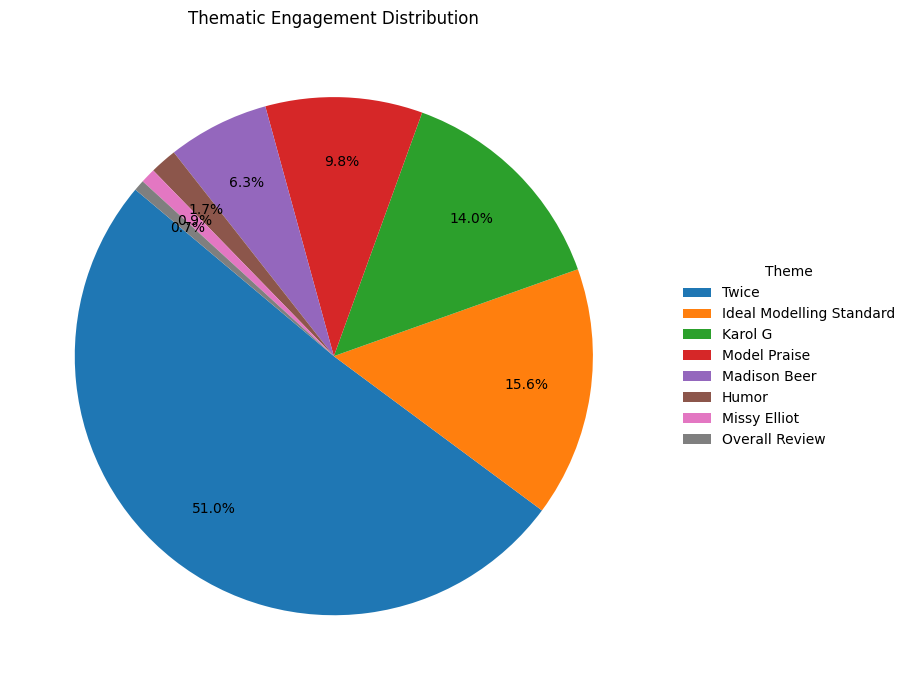


📁 Saved labeled top-35 TikTok comments to: top35_tiktok_comments_labeled_by_theme.csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- Load data ---
df_clean = pd.read_csv(CLEAN_TIKTOK_DATA)
print(f"Loaded TikTok dataset with {len(df_clean):,} rows.")

if "stable_index" not in df_clean.columns:
    df_clean["stable_index"] = df_clean.index
    print(
        "⚠️ 'stable_index' not found – created from current index. "
        "Make sure this matches how you chose indices for themes_by_index."
    )

themes_by_index = {
    "Humor": [633, 637],
    "Model Praise": [546, 274, 62, 55, 56, 53, 288],
    "Ideal Modelling Standard": [57, 58, 179, 63, 64, 65, 59, 56, 53],
    "Missy Elliot": [1661],
    "Twice": [762, 763, 760, 774, 783, 766, 169, 779, 769],
    "Karol G": [538, 767, 777, 542, 182, 761, 765],
    "Madison Beer": [765, 771],
    "Overall Review": [171],
}

text_col_name = None
for col in ["text", "content", "body", "comment"]:
    if col in df_clean.columns:
        text_col_name = col
        break
if text_col_name is None:
    raise ValueError("No text column found (expected 'text', 'content', 'body', or 'comment').")

likes_col_name = "likes"
if likes_col_name not in df_clean.columns:
    raise ValueError(f"Likes column '{likes_col_name}' not found in df_clean.")

subset = df_clean[["stable_index", text_col_name, likes_col_name]].copy()
subset = subset.rename(columns={text_col_name: "comment", likes_col_name: "likeCount"})

subset["likeCount"] = subset["likeCount"].fillna(0).astype(int)
subset["comment"] = subset["comment"].astype(str).fillna("").str.strip()

top_comments_df = (
    subset.sort_values("likeCount", ascending=False)
          .head(35)[["stable_index", "comment", "likeCount"]]
          .copy()
)

ranked = top_comments_df.reset_index(drop=True).copy()

index_to_themes = {}
for theme, indices in themes_by_index.items():
    for idx in indices:
        index_to_themes.setdefault(idx, []).append(theme)

def join_labels(idx):
    labs = index_to_themes.get(idx, [])
    return ", ".join(labs) if labs else ""

ranked["themes"] = ranked["stable_index"].apply(join_labels)

missing = ranked.loc[ranked["themes"].eq(""), "stable_index"].tolist()
if missing:
    print(f"⚠️ stable_index values in top-35 with NO theme label: {missing}")
else:
    print("✅ All top-35 TikTok comments have at least one theme label.")

ranked["theme_list"] = ranked["themes"].apply(
    lambda x: x.split(", ") if isinstance(x, str) and x else []
)

long = ranked.explode("theme_list").rename(columns={"theme_list": "theme"})
long = long[long["theme"] != ""]

counts = long.groupby("theme")["stable_index"].nunique().sort_values(ascending=False)
likes = long.groupby("theme")["likeCount"].sum().sort_values(ascending=False)

total_likes = likes.sum()

summary_df = pd.DataFrame({
    "Comments": counts,
    "Likes": likes,
    "Share of Likes (%)": (likes / total_likes * 100).round(1),
}).sort_values("Likes", ascending=False)

print("\n📊 THEME SUMMARY (Top 35 TikTok Comments)\n")
print(summary_df.to_string())

plt.figure(figsize=(10, 7))

wedges, texts, autotexts = plt.pie(
    summary_df["Likes"],
    labels=None,
    autopct="%1.1f%%",
    startangle=140,
    pctdistance=0.75
)

plt.title("Thematic Engagement Distribution")

plt.legend(
    wedges,
    summary_df.index,
    title="Theme",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)

plt.tight_layout()
plt.show()

# --- GitHub-ready output path ---
OUTPUT_DIR = Path("data/processed")
if not OUTPUT_DIR.exists():
    alt = Path("../data/processed")
    if alt.parent.exists():
        OUTPUT_DIR = alt

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

OUT_PATH = OUTPUT_DIR / "top35_tiktok_comments_labeled_by_theme.csv"
ranked.to_csv(OUT_PATH, index=False, encoding="utf-8")
print(f"\n📁 Saved labeled top-35 TikTok comments to: {OUT_PATH}")


In [ ]:
import pandas as pd
import textwrap
from pathlib import Path


CANDIDATE_PATHS = [
    Path("data/processed/top35_tiktok_comments_labeled_by_theme.csv"),
    Path("../data/processed/top35_tiktok_comments_labeled_by_theme.csv"),
]

LABELED_PATH = next((p for p in CANDIDATE_PATHS if p.exists()), None)
if LABELED_PATH is None:
    raise FileNotFoundError(
        "Could not find top35_tiktok_comments_labeled_by_theme.csv.\n"
        "Run the previous code block first to generate it.\n"
        "Expected: data/processed/top35_tiktok_comments_labeled_by_theme.csv"
    )

df_labeled_comments = pd.read_csv(LABELED_PATH)
print(f"✅ Loaded labeled TikTok comments from: {LABELED_PATH}")

if "index" in df_labeled_comments.columns:
    df_labeled_comments = df_labeled_comments.rename(columns={"index": "stable_index"})

df_labeled_comments["themes"] = df_labeled_comments["themes"].apply(
    lambda x: [theme.strip() for theme in x.split(",")] if pd.notna(x) and x else []
)

all_unique_themes = sorted(
    {theme for sublist in df_labeled_comments["themes"] for theme in sublist}
)

MAX_WIDTH = 100

print("\n=== TikTok Comments by Theme (Top 35) ===\n")

for theme in all_unique_themes:
    print(f"\n--- 🔵 Theme: {theme} ---")

    theme_comments = df_labeled_comments[
        df_labeled_comments["themes"].apply(lambda x: theme in x)
    ]

    if theme_comments.empty:
        print(f"  No comments found for '{theme}'.")
        continue

    theme_comments = theme_comments.sort_values(by="likeCount", ascending=False)

    for i, row in enumerate(theme_comments.itertuples(index=False), start=1):
        wrapped_comment = textwrap.fill(
            row.comment,
            width=MAX_WIDTH,
            break_long_words=False,
            replace_whitespace=False,
        )
        print(f"  {i}. 👍 {row.likeCount} likes  |  Index: {row.stable_index}")
        print(f"     {wrapped_comment}")
        print("-" * MAX_WIDTH)



=== TikTok Comments by Theme (Top 35) ===


--- 🔵 Theme: Humor ---
  1. 👍 11331 likes  |  Index: 633
     Mee
----------------------------------------------------------------------------------------------------
  2. 👍 7070 likes  |  Index: 637
     she's a model, we just ordinary girls 😂😂😂
----------------------------------------------------------------------------------------------------

--- 🔵 Theme: Ideal Modelling Standard ---
  1. 👍 48634 likes  |  Index: 57
     Models aren’t meant to be average or realistic…
----------------------------------------------------------------------------------------------------
  2. 👍 28546 likes  |  Index: 53
     I agree, for example when Yasmin Wijnaldum came out you could just tell she’s a model. 🔥
----------------------------------------------------------------------------------------------------
  3. 👍 27825 likes  |  Index: 56
     No because even plus size models, like Ashley Graham, you see her and you’re like yep that’s a
model, that’s he

**3.0 Sentiment Analysis**

This includes a sentiment analysis on the overall dataset, as well as a manual review of 100 comments. Here, the doubtful or incorrect classifications are separated for closer review, before calculating the accuracy rate.  

In [ ]:
!pip install -q transformers torch

import pandas as pd
import torch
import time
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# INPUT
df = pd.read_csv(CLEAN_TIKTOK_DATA)

# OUTPUT (GitHub/Colab friendly)
OUTPUT_DIR = Path("data/processed")
if not OUTPUT_DIR.exists():
    alt = Path("../data/processed")
    if alt.parent.exists():
        OUTPUT_DIR = alt

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
SENTIMENT_OUTPUT_PATH = OUTPUT_DIR / "cleaned_tiktok_data_sentiment.csv"


text_col = next((c for c in ["comment", "text", "content", "body"] if c in df.columns), None)
if text_col is None:
    raise ValueError("No text column found (expected one of: comment, text, content, body).")

df = df[~df[text_col].isin(["[deleted]", "[removed]"])].reset_index(drop=True)
df[text_col] = df[text_col].fillna("").astype(str)

print(f"✅ Loaded {len(df):,} TikTok comments")
print(f"📝 Using text column: {text_col}")

# Model
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    model_max_length=512,
    truncation=True,
    padding_side="right"
)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

device = 0 if torch.cuda.is_available() else -1
sentiment_pipeline = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=device
)


texts = df[text_col].tolist()
batch_size = 128
results = []

print("\n🔄 Running 3-class sentiment (pos/neu/neg) with truncation to 512 tokens...\n")
for i in range(0, len(texts), batch_size):
    batch = texts[i:i + batch_size]
    out = sentiment_pipeline(batch, truncation=True, padding=True, max_length=512)
    results.extend(out)

    if (i // batch_size) % 10 == 0:
        print(f"Processed {min(i + batch_size, len(texts))}/{len(texts)}", end="\r")

    time.sleep(0.01)

print("\n✅ Sentiment analysis complete!")

df["sentiment_label"] = [r["label"].upper() for r in results]
df["sentiment_score"] = [r["score"] for r in results]


df.to_csv(SENTIMENT_OUTPUT_PATH, index=False, encoding="utf-8")
print(f"💾 Saved TikTok sentiment file to:\n{SENTIMENT_OUTPUT_PATH}")

df[[text_col, "sentiment_label", "sentiment_score"]].head(5)


✅ Loaded 2,352 TikTok comments
📝 Using text column: comment


config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Device set to use cpu



🔄 Running 3-class sentiment (pos/neu/neg) with truncation to 512 tokens...


✅ Sentiment analysis complete!
💾 Saved TikTok sentiment file to:
/content/drive/MyDrive/Dataprojects/Methodology/cleaned_tiktok_data_sentiment.csv


,comment,sentiment_label,sentiment_score
0,Te amo,POSITIVE,0.732086
1,"if i want to see a fattie, I'll look in a mirror 😭",NEUTRAL,0.473997
2,who cares,NEGATIVE,0.475469
3,Were not Goddesses. No one is,NEGATIVE,0.541199
4,"Hahid sisters , Hailey walked so influencers could runnnn",NEUTRAL,0.402552


In [ ]:
import pandas as pd
from pathlib import Path

CANDIDATE_PATHS = [
    Path("data/processed/cleaned_tiktok_data_sentiment.csv"),
    Path("../data/processed/cleaned_tiktok_data_sentiment.csv"),
]

TIKTOK_SENTIMENT = next((p for p in CANDIDATE_PATHS if p.exists()), None)
if TIKTOK_SENTIMENT is None:
    raise FileNotFoundError(
        "Could not find cleaned_tiktok_data_sentiment.csv.\n"
        "Run the sentiment generation block first.\n"
        "Expected: data/processed/cleaned_tiktok_data_sentiment.csv"
    )

df_tiktok = pd.read_csv(TIKTOK_SENTIMENT)
print(f"Loaded {len(df_tiktok):,} TikTok rows from: {TIKTOK_SENTIMENT}")



Loaded 2,352 TikTok rows


In [ ]:
import pandas as pd

df_loaded = pd.read_csv(TIKTOK_SENTIMENT)

text_col = next(
    (c for c in ["text", "content", "body", "comment"] if c in df_loaded.columns),
    None
)

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", None)

df_loaded[[text_col, "sentiment_label", "sentiment_score"]].head(100)


,comment,sentiment_label,sentiment_score
0,Te amo,POSITIVE,0.732086
1,"if i want to see a fattie, I'll look in a mirror 😭",NEUTRAL,0.473997
2,who cares,NEGATIVE,0.475469
3,Were not Goddesses. No one is,NEGATIVE,0.541199
4,"Hahid sisters , Hailey walked so influencers could runnnn",NEUTRAL,0.402552
5,"100 percent agree, I do believe bella hadid has earned her place!",POSITIVE,0.851839
6,Yeah I want complete professionals supermodels only who can WALK,NEUTRAL,0.624477
7,i totally agree. it ruins the essence and originality of the show ugh,NEGATIVE,0.943855
8,It’s the Super Bowl of runway shows!!! The Stanley cup! The NBA finals!!!! I don’t wanna watch an average guy playing next to LeBron or tom Brady.,NEUTRAL,0.500148
9,yess clout is ruining it. gabi and quen should’ve never been allowed to step foot on that runway. they being behind tripods not on runways sorry. i’m not old enough to have watched the early 2000s shows but i can remember watching the 2016 one and being absolutely blown away and 2016 show is nothing compared to the early 2000s one. i didn’t even have a fraction of that feeling that i felt in 2016 for this yrs show :/ it’s tragic this has what’s happened to it,NEGATIVE,0.955089


In [ ]:
import pandas as pd

df = pd.read_csv(TIKTOK_SENTIMENT)

text_col = next((c for c in ["comment","text","content","body"] if c in df.columns), None)
if text_col is None:
    raise ValueError("No text column found in dataset.")

indices = [1, 6, 8, 11, 15, 16, 21, 26, 32, 51, 54, 69, 70, 71, 75, 81, 86, 89, 90, 97]

df.loc[indices, [text_col, "sentiment_label", "sentiment_score"]]


,comment,sentiment_label,sentiment_score
1,"if i want to see a fattie, I'll look in a mirror 😭",NEUTRAL,0.473997
6,Yeah I want complete professionals supermodels only who can WALK,NEUTRAL,0.624477
8,It’s the Super Bowl of runway shows!!! The Stanley cup! The NBA finals!!!! I don’t wanna watch an average guy playing next to LeBron or tom Brady.,NEUTRAL,0.500148
11,"Angels were models. Ans the top tier goddess models us mortals could barely comprehend. While all the influencers served and looked incredible, it’s now a very different show than what it once was",POSITIVE,0.608171
15,Truly you had to experience prime Gisele to understand,NEGATIVE,0.653207
16,THISSSSS !!! Thank youuuuuu!!!! Let them do Sports illustrated not VS!!!! Those women work so hard and now see that influencers are just being handed it and people wonder why some OG’s don’t return ..,POSITIVE,0.542220
21,Anok please look at her then look at us mere mortals cause no way she is not a beauty from another planet,NEGATIVE,0.445335
26,I watched it and I screamed when I saw Adriana Lima 😂😂😂,POSITIVE,0.504006
32,I still haven’t watched the Victoria secret fashion show and I’m desperate to💞,NEGATIVE,0.571313
51,"They tried avoiding these cultural shifts (happening across the beauty industry) and revenue fell. These *new* opinions actually do matter because VS is growing their customer base, hence the influencers. I do think they should be prepped more by the brand (they could even turn that into marketing content), but influencers aren’t going anywhere anytime soon.. “You weren’t there” isn’t enough to turn a profit, but in the current attention economy, clout is 😬. That’s why they’ve changed their tune after the success of shows like Fenty (which had influencers, reality show stars, etc). Hate it or love it, ppl who *do* want to see themselves in that fantasy are voting with their dollar and attention, so changes are being made 💰",NEGATIVE,0.637355


**Review of misclassifications**


This dataset includes a lot of slang, like ‘ ate’, ‘eat down’ and ‘ ate hard’, which is a complimentary reference yet wrongly classified as negative. Comments where people expressed their aspirations for the show, like ‘only who can WALK’ being desired, not ‘an average guy playing next to LeBron’, subtly highlight the inadequacies of the show, therefore better suited as a negative sentiment, although the current neutral sentiment is not completely wrong either. Furthermore, many comments included mixed emotions, expressing a positive review yet wondering why there are so many negative responses. Technically this would be a positive sentiment, yet it is classified as negative. Then there are some comments with little to no context, naming the models with some emoji’s, or including expressions like ‘my jaw was on the floor’, or ‘i screamed’ which could be interpreted in different ways. This makes categorisation difficult, as more contextual awareness is needed. Therefore, classifications of positive or negative seem unreliable.



*Accuracy rate of 80%*

**3.1 Sentiment Popularity**

This reviews the popularity of each sentiment, first by reviewing their overall presence in the dataset, the top comments of each sentiment and the average like count per category.

✅ Loaded 2,352 rows with sentiment data


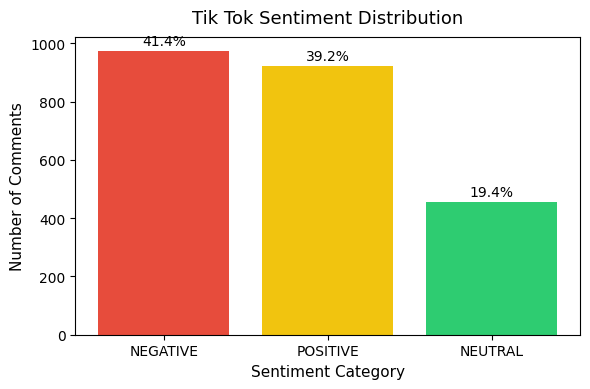


📊 Sentiment Breakdown:
NEGATIVE: 41.41% (974 comments)
POSITIVE: 39.20% (922 comments)
NEUTRAL: 19.39% (456 comments)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(TIKTOK_SENTIMENT)
print(f"✅ Loaded {len(df):,} rows with sentiment data")


counts = df["sentiment_label"].value_counts()
percentages = (counts / counts.sum() * 100).round(2)

plt.figure(figsize=(6, 4))
bars = plt.bar(counts.index, counts.values, color=["#E74C3C", "#F1C40F", "#2ECC71"])

plt.title("Tik Tok Sentiment Distribution", fontsize=13, pad=10)
plt.xlabel("Sentiment Category", fontsize=11)
plt.ylabel("Number of Comments", fontsize=11)
plt.xticks(rotation=0)


for bar, pct in zip(bars, percentages):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + counts.max() * 0.01,
        f"{pct:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10,

    )

plt.tight_layout()
plt.show()

print("\n📊 Sentiment Breakdown:")
for label, pct in percentages.items():
    print(f"{label}: {pct:.2f}% ({counts[label]} comments)")


In [ ]:
import pandas as pd


df_sentiment = pd.read_csv(TIKTOK_SENTIMENT)
df_sentiment.columns = df_sentiment.columns.str.lower()


text_col = next((c for c in ["comment","text","content","body"] if c in df_sentiment.columns), None)
if text_col is None:
    raise ValueError("No comment column found.")

df_sentiment = df_sentiment.rename(columns={
    text_col: "comment",
    "diggcount": "likes"
})


df_sentiment["likes"] = pd.to_numeric(df_sentiment["likes"], errors="coerce").fillna(0).astype(int)


df_sentiment["sentiment_label"] = df_sentiment["sentiment_label"].astype(str).str.lower()


if "sentiment_score" in df_sentiment.columns:
    df_sentiment = df_sentiment.rename(columns={"sentiment_score": "confidence"})


def print_top(df, sentiment_type, icon):
    subset = (
        df[df["sentiment_label"] == sentiment_type]
        .sort_values("likes", ascending=False)
        .head(15)
    )

    print(f"\n{icon} Top 15 Most-Liked {sentiment_type.capitalize()} Comments:\n")
    for _, row in subset.iterrows():
        snippet = str(row["comment"])[:500]
        print(f"💬 {snippet}")
        print(f"   🔹 Sentiment: {row['sentiment_label']} "
              f"({row['confidence']:.3f}) | Likes: {row['likes']}\n")

print_top(df_sentiment, "negative", "🔴")
print_top(df_sentiment, "positive", "🟢")
print_top(df_sentiment, "neutral", "🟡")



🔴 Top 15 Most-Liked Negative Comments:

💬 twice was so off key i’m crying 😭
   🔹 Sentiment: negative (0.924) | Likes: 173792

💬 What the HELL was going on with twice
   🔹 Sentiment: negative (0.774) | Likes: 135749

💬 Twice was so bad 😭😭
   🔹 Sentiment: negative (0.934) | Likes: 52550

💬 "Tzuyu was sick!" "They're on tour and didn't have time to practice!" well guess what, they accepted the offer to perform on Victoria's secret knowing damn well they ain't ready 😭
   🔹 Sentiment: negative (0.949) | Likes: 20734

💬 twice literally sounded so so bad i was crying 😭
   🔹 Sentiment: negative (0.915) | Likes: 16153

💬 twice was really hard to listen
   🔹 Sentiment: negative (0.904) | Likes: 13867

💬 If Tate McRae replaced twice it would’ve ate
   🔹 Sentiment: negative (0.540) | Likes: 13756

💬 The Pink segment was messy for me. You can visibly tell the difference between supermodels and influencers lol
   🔹 Sentiment: negative (0.808) | Likes: 11846

💬 "don't know much about her" and it's l

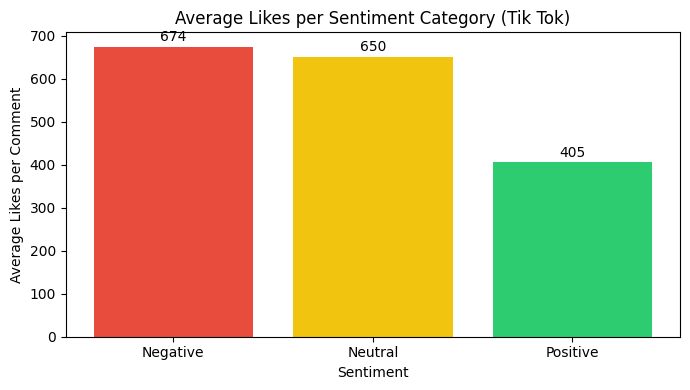


📊 Sentiment Popularity Summary:
Negative: 974 comments | Avg Likes: 674.4 | Total Likes: 656912
Neutral: 456 comments | Avg Likes: 649.9 | Total Likes: 296338
Positive: 922 comments | Avg Likes: 405.4 | Total Likes: 373814


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


df = pd.read_csv(TIKTOK_SENTIMENT)

df.columns = df.columns.str.lower()


text_col = next((c for c in ["comment","text","content","body"] if c in df.columns), None)
if text_col is None:
    raise ValueError("No comment column found.")


df = df.rename(columns={
    text_col: "comment",
    "diggcount": "likes"
})

df["likes"] = pd.to_numeric(df["likes"], errors="coerce").fillna(0)

df["sentiment_label"] = df["sentiment_label"].astype(str).str.lower()


df["sentiment_label_plot"] = df["sentiment_label"].str.title()

sentiment_stats = (
    df.groupby("sentiment_label_plot")["likes"]
      .agg(["mean", "sum", "count"])
      .reset_index()
      .sort_values("mean", ascending=False)
)

# Colors for chart
color_map = {
    "Positive": "#2ECC71",
    "Neutral": "#F1C40F",
    "Negative": "#E74C3C"

}
colors = [color_map.get(label, "gray") for label in sentiment_stats["sentiment_label_plot"]]

plt.figure(figsize=(7,4))
bars = plt.bar(sentiment_stats["sentiment_label_plot"], sentiment_stats["mean"], color=colors)
plt.title("Average Likes per Sentiment Category (Tik Tok)")
plt.ylabel("Average Likes per Comment")
plt.xlabel("Sentiment")

y_pad = sentiment_stats["mean"].max() * 0.01
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + y_pad,
        f"{bar.get_height():.0f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.show()

print("\n📊 Sentiment Popularity Summary:")
for _, row in sentiment_stats.iterrows():
    print(f"{row['sentiment_label_plot']}: {int(row['count'])} comments | "
          f"Avg Likes: {row['mean']:.1f} | Total Likes: {row['sum']:.0f}")


**4.0 Text Frequency Analysis**

This part includes an analysis of the most frequent words in the dataset. From the most frequent or thematically relevant words, the top 10 most liked comments are reviewed, to gain deeper contextual awareness.

In [ ]:
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display

nltk.download("stopwords", quiet=True)

df = pd.read_csv(CLEAN_TIKTOK_DATA)
print(f"✅ Loaded {len(df):,} rows from {CLEAN_TIKTOK_DATA}")

text_col = next((c for c in ["comment", "text", "content", "body"] if c in df.columns), None)
if text_col is None:
    raise ValueError("❌ No text column found (expected one of: comment, text, content, body).")

df[text_col] = df[text_col].fillna("").astype(str).str.strip()
df = df[df[text_col].str.len() >= 5].copy()
print(f"🧹 Kept {len(df):,} comments with ≥5 characters")

stop_words = set(stopwords.words("english"))

project_stopwords = {"dont", "thats", "didnt", "like", "think", "would"}
stop_words |= project_stopwords

junk_tokens = {"s", "t", "m", "g", "1", "000", "la", "de", "se", "las", "el", "que"}
stop_words |= junk_tokens


vectorizer = CountVectorizer(
    stop_words=list(stop_words),
    lowercase=True,
    token_pattern=r"(?u)\b[a-zA-Z]{2,}\b"
)

X = vectorizer.fit_transform(df[text_col])
counts = X.sum(axis=0).A1
words = vectorizer.get_feature_names_out()

top_words = (
    pd.DataFrame({"word": words, "count": counts})
      .sort_values("count", ascending=False)
      .head(15)
      .reset_index(drop=True)
)

top_words.index = top_words.index + 1

print("\nTop 15 Words in TikTok Dataset:")
display(
    top_words.style.set_properties(**{
        "border": "1px solid black",
        "text-align": "left",
    })
)


✅ Loaded 2,352 rows from /content/drive/MyDrive/Dataprojects/Methodology/tiktok_cleaned_comments.csv
🧹 Kept 2,185 comments with ≥5 characters

Top 15 Words in TikTok Dataset:


,word,count
1,show,209
2,models,158
3,vs,148
4,twice,125
5,karol,124
6,people,110
7,year,88
8,want,84
9,love,84
10,agree,76


In [ ]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 100)

TOP_N_WORDS = 15
TOP_N_COMMENTS = 15

for word in top_words["word"].head(TOP_N_WORDS):
    subset = df[
        df[text_col].str.contains(rf"\b{word}\b", case=False, regex=True)
    ]

    if subset.empty:
        continue

    top_comments = (
        subset.sort_values("likes", ascending=False)
              .head(TOP_N_COMMENTS)[[text_col, "likes", "stable_index"]]
              .reset_index(drop=True)
    )

    print(f"\n🔹 Top {TOP_N_COMMENTS} most-liked comments containing '{word}':\n")
    display(top_comments)



🔹 Top 15 most-liked comments containing 'show':



,comment,likes,stable_index
0,This queen repaired the show,57887,761
1,Karol G was the best performance I’ve seen in a minute and the best section of the show,22475,767
2,"idc how controversial this is - models should be tall and lean. and agreed, vs show should only hire actual models cuz watching influencers or what not trying to runway walk was painful",9743,63
3,"KAROL SALVO ESE SHOW, LITERAL",3163,540
4,"it was never about the body to me, other girls could be ultra skinny but if they don't have the walk, the attitude or the face card it doesn't really matter, Ashley Graham had one of the best moments in the show for me",2696,69
5,Missy Elliot had a whole halftime superbowl show /: i love her music but for VS Fashion Show it was not so classy,1813,184
6,Madison Beer was giving ethereal pretty angel vibes and was so perfect to open the show with the pretty pink looks and her face card ate down at the end😩 and Karol G was givingggg.,1417,775
7,Without Angel I wouldn't have even been aware that VS show was on. Well done Angel,699,1141
8,Is it not easy to say “Twice”? 💀 You watched the whole show and their name was on the big screen at the end of their section …,629,1346
9,I'ma need a Sabrina carpenter VS show,588,952



🔹 Top 15 most-liked comments containing 'models':



,comment,likes,stable_index
0,Models aren’t meant to be average or realistic…,48634,57
1,"No because even plus size models, like Ashley Graham, you see her and you’re like yep that’s a model, that’s her profession; it’s not just about body type",27825,56
2,"idc how controversial this is - models should be tall and lean. and agreed, vs show should only hire actual models cuz watching influencers or what not trying to runway walk was painful",9743,63
3,Even the curvy models have a standard,7995,64
4,"I worked with models.. you literally see them in a room full of people and they'll stand out.. even when they're seated.. they have some type of aura with them, that the ""regular"" people just simply don't have.. and its never about their face card.. they can be unattractive, but their height and presence and the way they carry themselves as an individual.. is what give them that model material.. and we saw that clearly on the runway",6319,59
5,models are aspirational figures like supercars. it's not practical but its beautiful to look at,3732,67
6,"I wish when it came to inclusivity they would focus more on models like Awar Odhiang, she was absolutely breathtaking! There was one look where I had to gasp.",3465,80
7,"if VS og models retired, VSFS is over. i don't want to see influencers or tiktokers modeling in VSFS too.",3337,60
8,Yes!! Models used to cry when getting their wings. 🪽,2442,334
9,I thinks it's the clothes not the models,2077,1355



🔹 Top 15 most-liked comments containing 'vs':



,comment,likes,stable_index
0,"idc how controversial this is - models should be tall and lean. and agreed, vs show should only hire actual models cuz watching influencers or what not trying to runway walk was painful",9743,63
1,"Cuando le tocó a Karol sentí el vs de antes, las chicas se soltaron y se divirtieron",7548,542
2,"Madison is perfectt for VS, Twice was really embarrassing 😭",4716,1319
3,"if VS og models retired, VSFS is over. i don't want to see influencers or tiktokers modeling in VSFS too.",3337,60
4,Also it seems like the “supermodel” era is kinda dead. Who is going to replace the fame of Candace or Adriana for VS?,2163,149
5,idk but this year vs ate especially with Bella Hadid,2044,181
6,"I grew up as an 80s baby. VS shows were literally ANGELS. It was like dreamwoks. We KNEW it wasn’t attainable. We enjoyed the women for being magical beings. No more, no less.",1835,73
7,Missy Elliot had a whole halftime superbowl show /: i love her music but for VS Fashion Show it was not so classy,1813,184
8,Candace Swanepoel was literally gliding and floating on that runway. You could tell a VS Vet was walking,1374,75
9,People forget that modeling is a job and VS models are the top 1% of their profession. Would you go to a hospital and demand that a random bio student from HS operates along side a seasoned surgeon in the name of inclusivity? I bet not,821,79



🔹 Top 15 most-liked comments containing 'twice':



,comment,likes,stable_index
0,twice was so off key i’m crying 😭,173792,762
1,What the HELL was going on with twice,135749,763
2,Should’ve had katseye instead of twice,118847,760
3,Twice was so bad 😭😭,52550,774
4,twice literally sounded so so bad i was crying 😭,16153,783
5,twice was really hard to listen,13867,769
6,If Tate McRae replaced twice it would’ve ate,13756,169
7,I expected more from Twice tbh,11348,779
8,"Madison is perfectt for VS, Twice was really embarrassing 😭",4716,1319
9,I feel like Twice would have been better if they had the whole group,3895,787



🔹 Top 15 most-liked comments containing 'karol':



,comment,likes,stable_index
0,madison beer and karol g ATE DOWNNNN,39994,765
1,Karol G was the best performance I’ve seen in a minute and the best section of the show,22475,767
2,Y TODOS DECIAN Q KAROL G NO PEGABA 😭😭😭,7950,777
3,"Cuando le tocó a Karol sentí el vs de antes, las chicas se soltaron y se divirtieron",7548,542
4,KAROL G!!!!! Was amaaaaazing,7295,182
5,"Madison and Karol slayed, others were mistake where is tate and sabrina here?",6268,818
6,Karol g le cerró la boca a más de uno 💋,5689,776
7,Karol G was FIRE,5527,770
8,Karol g ate,4625,773
9,My girl Karol G did so freaking goodddd🩷🪽,4442,764



🔹 Top 15 most-liked comments containing 'people':



,comment,likes,stable_index
0,Supermodels shouldn’t be on the runway with regular people. Like the difference was crazy,6414,65
1,"I worked with models.. you literally see them in a room full of people and they'll stand out.. even when they're seated.. they have some type of aura with them, that the ""regular"" people just simply don't have.. and its never about their face card.. they can be unattractive, but their height and presence and the way they carry themselves as an individual.. is what give them that model material.. and we saw that clearly on the runway",6319,59
2,They used to have open calls for fresh faces that were hungry to perform. Now they just select the same people.,2393,350
3,People thinking it’s the models but really it’s the outfits😌,1553,1363
4,I don’t think people like to admit that modelling is a job that requires skills and training which professional models have been perfecting throughout their years of experience. It becomes very visible when you put them next to someone whose job is not modelling.,880,77
5,People forget that modeling is a job and VS models are the top 1% of their profession. Would you go to a hospital and demand that a random bio student from HS operates along side a seasoned surgeon in the name of inclusivity? I bet not,821,79
6,"also, I feel like they used to scout women across the world that had worked really hard. And now it’s just either the same people or hand selected influencers/nepo babies but they’re not looking for those like diamonds in the rough - thoughts???",670,341
7,i hate the comments every year because people are just using it as a free for all to be fatphobic and transphobic when those types of comments from the brand is the reason why the show got cancelled in the first place 🙃,325,746
8,"Review aside, are people just gonna call all kpop “kpop demon hunters” now or am I missing something?",258,1961
9,personally for me I really loved it because it included people with different types of body types 🔥,235,1359



🔹 Top 15 most-liked comments containing 'year':



,comment,likes,stable_index
0,idk but this year vs ate especially with Bella Hadid,2044,181
1,I agreeeee!! Def better than last year but still needing a few tweaks to it,768,1338
2,"I wish they had done more intricate styling & fantasy/costume looks like these old ones. the details matter so much, shoes, jewelry, props, hats,gloves etc to elevate the outfits. the wings still looked cheap but way better than 2024. the models were struggling with the shoes just like last year :(",629,176
3,"it was for sure better than last year! stage, hairstyles etc the camera work was better ane models walking wasn’t so messy. I wish the looks were more thought out, some of them looked like they had 2 weeks to plan not a year! more props, interesting themes needed",517,183
4,next year I WANT TATE MCRAEEEEEEE,496,2177
5,"again, back from last year, I agree on all your points here. I guess they're ditching the fantasy bra for now. They almost went bankrupt in 2020",373,425
6,i hate the comments every year because people are just using it as a free for all to be fatphobic and transphobic when those types of comments from the brand is the reason why the show got cancelled in the first place 🙃,325,746
7,"specifically excluding Pink in the older VS fashion show clips, excluding the incredible looks in this year (that happen to be in other post on this page), and showing curvy models in the “bad section”. i thought this magazine was about truth and uplifting women, not sad attempts to cause division.",195,1364
8,Madison beer carried the performances this year,134,1347
9,In my opinion they NEED to have Tate McRae to sing next year!!,131,951



🔹 Top 15 most-liked comments containing 'want':



,comment,likes,stable_index
0,"if VS og models retired, VSFS is over. i don't want to see influencers or tiktokers modeling in VSFS too.",3337,60
1,"everyone was trying to serve too much face. like we alrdy know yall got it, i want them prancing and dancing and giggly it was a lil tooooo serious",1799,1331
2,Exactly! We want the fantasy!,924,78
3,Everyone waited for twice and left disappointed and everyone didnt want karol g to participate and they left saying she had the best performance,862,988
4,"Lucky me, I can eat anything I want and never gain weight. 😀",826,639
5,next year I WANT TATE MCRAEEEEEEE,496,2177
6,Yes. We want supermodels only,461,1290
7,"I want to see my type of body (which is mid size body with stretch marks and cellulite) on the website when I go there to buy some pants or bra. But when it comes to the runway show ESPECIALLY the VSFS, I want to see unrealistic body, glitter and blowouts. Bring back 2010s VSFS",430,1298
8,I want to but theres no vs stores in my country!! 😊🔫,403,95
9,"as kpopers i know Twice vocals have never been their strong point but is in big Event and i know they want too make more international fans, they have too know vocal standard in US is No joke and their English pronunciation still needs a lot work",301,1669



🔹 Top 15 most-liked comments containing 'love':



,comment,likes,stable_index
0,Missy Elliot had a whole halftime superbowl show /: i love her music but for VS Fashion Show it was not so classy,1813,184
1,I LOVE KAROL G PERIODD,1218,778
2,so glad to see karol g love 💗,553,1654
3,also I love the generation of girls who will now connect sporting and athletic bodies with models !!! as they SHOULD,524,1144
4,i love us so bad,413,284
5,"twice schedules are so so crazy. new mv, crazy world tour and nonstop album drops and promotions. i love them and theyre amazing performers usually but its so obvious how overworked they are from these schedules :( and jyp just added more tour dates like whaaatttt",212,2162
6,"For the love of God, some things are intended to be exclusive — bring back OG VS fashion shows ✨",134,1361
7,My controversial opinion was that twice jus werebt that good like theyre beautiful and i love them but they seem so low energy which like dosent siit pink at all and something abt them was rlly off idk,109,209
8,I love blonde hair on Bella Hadid. that is all,56,2299
9,so I think the reason why Tate McRae wasn't there I'm pretty sure he had a concert I'm pretty sure that is the reason I loved every performance though also I love your pajamas,54,1034



🔹 Top 15 most-liked comments containing 'agree':



,comment,likes,stable_index
0,"I agree, for example when Yasmin Wijnaldum came out you could just tell she’s a model. 🔥",28546,53
1,I AGREE!!!!! Karol G ate and left NO CRUMBSSSS. I was thinking the same thing about missy 😭😩😩😩,3203,1321
2,Totally agree! In the most non-rude way did it feel like supermodels smiled at the end of the runway & others just looked way too serious… like usually VS has more of the fun/bubbly element in facial expressions? I could be way off though,687,1345
3,The group is called Twice - not K-pop demon hunters FYI lol. One of the songs they performed was from the K-pop demon hunters album but I agree with all of your other takes,616,1339
4,The pink section was AWFUL!!! I actually hated it and I feel like no one is talking about it. The walks were horrid and the looks were blah except for maybe 2-3. I actually couldn’t wait for that part to be over. Totally agree with everything you’re saying!!,490,1341
5,"again, back from last year, I agree on all your points here. I guess they're ditching the fantasy bra for now. They almost went bankrupt in 2020",373,425
6,I agree 100% !!! Everyone is saying it was bad but this is the closer thing I’ve felt to the og show !!!!,352,1036
7,I agree. Which is why I was obsessed with Amelia Gray’s walk✨,191,348
8,"I agree it was very slow, I was waiting for them to hype it up. Missy Elliott also seemed out of place, but her performance was good",157,964
9,i totally agree. it ruins the essence and originality of the show ugh,126,7



🔹 Top 15 most-liked comments containing 'victoria':



,comment,likes,stable_index
0,"""Tzuyu was sick!"" ""They're on tour and didn't have time to practice!"" well guess what, they accepted the offer to perform on Victoria's secret knowing damn well they ain't ready 😭",20734,766
1,Twice songs are kinda childish it doesn't suit Victoria secret 😶,838,2174
2,"I don't want to see inclusivity...victoria secret was like the olympics. I want supermodels in victoria secret, I was smart people as doctors and I want the best athletes in olympics.",147,147
3,y pensar que decían que Karol G iba a ser la decadencia de Victoria Secret y fue la mejor. Nada mejor cuando subestiman a alguien y da el triple ❤,118,564
4,"Victoria secret angels aren’t supposed to be every day people, and it’s fine",101,74
5,"tava com umas amigas e uma delas disse que não concorda com corpos plus size em desfiles, porque Victoria Secrets segundo ela é um desfile com corpos irreais.",90,1688
6,KAROL G ATE AND GAVE US VICTORIA SECRET ESSENCE,86,788
7,"Passion. I like passion, the girls that used to walk the runway literally dedicated their entire lives to the Victoria’s Secret runway shows. To these girls, it’s just a fun event that they got invited to.",72,381
8,Victoria's Secret ❤️‍🔥,48,2107
9,"although quen may be an influencer, i thought she was absolutely perfect for victoria secret and has the look for it",48,1447



🔹 Top 15 most-liked comments containing 'secret':



,comment,likes,stable_index
0,"""Tzuyu was sick!"" ""They're on tour and didn't have time to practice!"" well guess what, they accepted the offer to perform on Victoria's secret knowing damn well they ain't ready 😭",20734,766
1,Twice songs are kinda childish it doesn't suit Victoria secret 😶,838,2174
2,Tanto que la gente criticó a Karol G y fue la única que me dio Victorias Secret ❤,160,547
3,"I don't want to see inclusivity...victoria secret was like the olympics. I want supermodels in victoria secret, I was smart people as doctors and I want the best athletes in olympics.",147,147
4,y pensar que decían que Karol G iba a ser la decadencia de Victoria Secret y fue la mejor. Nada mejor cuando subestiman a alguien y da el triple ❤,118,564
5,"Victoria secret angels aren’t supposed to be every day people, and it’s fine",101,74
6,KAROL G ATE AND GAVE US VICTORIA SECRET ESSENCE,86,788
7,"Passion. I like passion, the girls that used to walk the runway literally dedicated their entire lives to the Victoria’s Secret runway shows. To these girls, it’s just a fun event that they got invited to.",72,381
8,"although quen may be an influencer, i thought she was absolutely perfect for victoria secret and has the look for it",48,1447
9,Victoria's Secret ❤️‍🔥,48,2107



🔹 Top 15 most-liked comments containing 'good':



,comment,likes,stable_index
0,Madison did soo good her voice was so stable,29207,771
1,karol g was only good cus she was lip syncingggg,571,809
2,Lowk has nothing to do with the models…. VS looks just aren’t as good as they used to be,465,300
3,Katseye would have been good for the show,267,1416
4,"I agree it was very slow, I was waiting for them to hype it up. Missy Elliott also seemed out of place, but her performance was good",157,964
5,Angel Reese looks so good!!!!,148,421
6,"For all the girls deciding not to eat, she looks so good cause she has muscle mass! Eat girl, eat clean, eat protein and go to the gym",127,653
7,it was so good tho idek why people are complaining,125,97
8,My controversial opinion was that twice jus werebt that good like theyre beautiful and i love them but they seem so low energy which like dosent siit pink at all and something abt them was rlly off idk,109,209
9,"Why is no one talking about Imaan Hammam , she was so good !",88,201



🔹 Top 15 most-liked comments containing 'madison':



,comment,likes,stable_index
0,madison beer and karol g ATE DOWNNNN,39994,765
1,Madison did soo good her voice was so stable,29207,771
2,"Madison and Karol slayed, others were mistake where is tate and sabrina here?",6268,818
3,Did no one else feel like Madison was lip syncing???😭,5228,173
4,"Madison is perfectt for VS, Twice was really embarrassing 😭",4716,1319
5,Madison Beer was giving ethereal pretty angel vibes and was so perfect to open the show with the pretty pink looks and her face card ate down at the end😩 and Karol G was givingggg.,1417,775
6,"after Twice performance, Madison’s performance felt like a breeze that cooled down the embarrassment 💀",558,831
7,"Everyone is hating on twice but at least they weren’t lip syncing? Is it only me but I loved them and the theme, also madison beer definitely had backing tracks and was lip syncing I’m glad twice was live.",397,178
8,Madison’s performance gave peak VS. I don’t think she should’ve been swapped. I think twice or missy elliot should’ve been swapped. Tate AND Madison performing at the VSFS?! That would’ve ate downnnn!,345,1031
9,1. Missy Elliot 2. Karol G 3. Madison Beer 4. Twice,297,833



🔹 Top 15 most-liked comments containing 'one':



,comment,likes,stable_index
0,Y is everybody forgetting Jasmine Tookes 🤦🏾‍♀️One of the ogs. She looked like she was in a different dimension,7413,274
1,Did no one else feel like Madison was lip syncing???😭,5228,173
2,who was the first one please she’s gorgeous,3649,277
3,"I wish when it came to inclusivity they would focus more on models like Awar Odhiang, she was absolutely breathtaking! There was one look where I had to gasp.",3465,80
4,"it was never about the body to me, other girls could be ultra skinny but if they don't have the walk, the attitude or the face card it doesn't really matter, Ashley Graham had one of the best moments in the show for me",2696,69
5,The group is called Twice - not K-pop demon hunters FYI lol. One of the songs they performed was from the K-pop demon hunters album but I agree with all of your other takes,616,1339
6,The pink section was AWFUL!!! I actually hated it and I feel like no one is talking about it. The walks were horrid and the looks were blah except for maybe 2-3. I actually couldn’t wait for that part to be over. Totally agree with everything you’re saying!!,490,1341
7,I’m so glad I wasn’t the only one who thought this,108,1109
8,I THOUGHT I WAS THE ONLY ONE WHO DIDNT LIKE THE BRA OVER THE SHIRT,102,1432
9,"Why is no one talking about Imaan Hammam , she was so good !",88,201


**5.0 Topic Modelling**

This part conducts topic modelling on the entire dataset using semantic embeddings, which capture the meaning of the word and don’t rely exclusively on frequency patterns.

In [ ]:
!pip install -q bertopic sentence-transformers umap-learn hdbscan nltk

import pandas as pd
import nltk
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords


df_tiktok = pd.read_csv(CLEAN_TIKTOK_DATA)
print(f"✅ Loaded cleaned TikTok dataset with {len(df_tiktok):,} rows")


text_col = next((c for c in ["comment", "text", "content", "body"] if c in df_tiktok.columns), None)
if text_col is None:
    raise ValueError("❌ No text column found (expected one of: comment, text, content, body).")

df_tiktok[text_col] = df_tiktok[text_col].fillna("").astype(str)


df_tiktok[text_col] = df_tiktok[text_col].astype(str)
df_tiktok = df_tiktok[df_tiktok[text_col].str.strip().ne("")].copy()
print(f"🧹 Kept {len(df_tiktok):,} comments")


df_tiktok["char_len"] = df_tiktok[text_col].str.len()
df_tiktok["is_short"] = df_tiktok["char_len"] < 5


# Stopwords
nltk.download("stopwords")

stopwords_multi = (
    set(stopwords.words("english"))
    | set(stopwords.words("spanish"))
    | set(stopwords.words("portuguese"))
    | {
        "https", "http", "www", "com", "jpg", "removed", "deleted", "amp",
        "vs", "victoria", "secret"
    }
)
stopwords_multi = list(stopwords_multi)

vectorizer_model = CountVectorizer(
    stop_words=stopwords_multi,
    token_pattern=r"[A-Za-z\u00C0-\u00FF']{3,}",
    min_df=1,
    max_df=0.9,
    ngram_range=(1, 2)
)

embedding_model = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")

topic_model = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    language="multilingual",
    min_topic_size=45,
    calculate_probabilities=True,
    verbose=True
)

# Fit model
texts = df_tiktok[text_col].tolist()
topics, probs = topic_model.fit_transform(texts)
df_tiktok["bertopic_topic"] = topics

# Topic overview
pd.set_option("display.max_colwidth", None)
topic_info = topic_model.get_topic_info()
print(f"\n📊 Topic overview (all {len(topic_info)} topics):")
print(topic_info.to_string(index=False))

# Sanity check to ensure everything is assigned a topic
print("\n✅ Sanity check:")
print("Rows in df_tiktok:", len(df_tiktok))
print("Topic assignments:", df_tiktok["bertopic_topic"].notna().sum())
print("\nTopic distribution:")
print(df_tiktok["bertopic_topic"].value_counts().sort_index())

# Inspect topics (excluding outliers)
all_topics = topic_info[topic_info["Topic"] != -1]["Topic"].tolist()

print("\n🔍 Inspecting ALL topics (excluding -1 outliers) with example comments:")
for t in all_topics:
    print("\n" + "=" * 60)
    print(f"🧩 Topic {t}")
    print("Top words:", topic_model.get_topic(t))
    print("\n💬 Sample comments:")

    sample_comments = df_tiktok.loc[df_tiktok["bertopic_topic"] == t, text_col].head(15)
    for i, c in enumerate(sample_comments, start=1):
        print(f"{i:2d}. {c}")



✅ Loaded cleaned TikTok dataset with 2,352 rows
🧹 Kept 2,352 comments


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2026-01-01 00:49:48,995 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/74 [00:00<?, ?it/s]

2026-01-01 00:53:13,257 - BERTopic - Embedding - Completed ✓
2026-01-01 00:53:13,259 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-01 00:53:26,669 - BERTopic - Dimensionality - Completed ✓
2026-01-01 00:53:26,670 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-01 00:53:26,862 - BERTopic - Cluster - Completed ✓
2026-01-01 00:53:26,867 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-01 00:53:26,954 - BERTopic - Representation - Completed ✓
2026-01-01 00:53:27,102 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.



📊 Topic overview (all 7 topics):
 Topic  Count                                 Name                                                                                                                  Representation                                                                                                                                                                                                                                                                                                                                                                                                                                                       Representative_Docs
    -1    624          -1_candice_pink_twice_angel                                               [candice, pink, twice, angel, demon, demon hunters, hunters, black, like, creepy]                                                                                                                                                       